In [1]:
!pip install -r requirements.txt

  Cloning https://github.com/TinArmEngineering/tinarm.git (to revision 0.1.48) to /tmp/pip-req-build-wq12i8k_
  Running command git clone --filter=blob:none --quiet https://github.com/TinArmEngineering/tinarm.git /tmp/pip-req-build-wq12i8k_
  Running command git checkout -q 4c399237d29214e757d5c082ca223ea8371a7d77
  Resolved https://github.com/TinArmEngineering/tinarm.git to commit 4c399237d29214e757d5c082ca223ea8371a7d77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import matplotlib.pyplot as plt
import pint
from tinarm import NameQuantityPair
from tinarm import Quantity 
from tinarm.api import JOB_STATUS

import tinarm
import logging
import time
import requests
import uuid
import random
import yaml
import pandas as pd
import pint_pandas


In [3]:

LOGGING_LEVEL = logging.INFO
STATUS_JOB = {value:key for key,value in JOB_STATUS.items()}

In [4]:

### Configure Logging
logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-01-18 20:55:41,071 - NoJobId - INFO - Kebnekaise - 1683099798.py-><module>() - tinarm version 0.1
2024-01-18 20:55:41,072 - NoJobId - INFO - Kebnekaise - 1683099798.py-><module>() - pint_pandas version 0.5


Log in to Tin Arm Engineering's machine solver, and under profile, retrieve your API key. 
Do not commit your API key to a repository, and consider it like a password.  A good way to keep it out of this code base is to use a configuation file, or environment variable. We will want other things cofigured too, so let's use a yaml file for convenience. 

create a `configurations.yaml` file in this directory with the content.
```yaml
api_key: 668952058c490d0a296da0abb966****
root_url: http://server-go:4300
```
But of course replace the number with your api key

You can then add that file to your `.gitignore` file by executing ```echo 'configurations.yaml' >> .gitignore```

```
!echo 'configurations.yaml' >> .gitignore
```

In [5]:
with open("configurations.yaml", "r") as f:
    config = yaml.safe_load(f)

# Stator

In [6]:
stator_parameters = {
    "slot_liner_thikness": 200 * q.um,
    "stator_bore": 8.20 * q.cm,
    "tooth_tip_depth": 1.5 * q.mm,
    "slot_opening": 1.5 * q.mm,
    "tooth_width": 9.8 * q.mm,
    "stator_outer_diameter": 136 * q.mm,
    "back_iron_thickness": 5.5 * q.mm,
    "stator_internal_radius": 1 * q.mm,
    "number_slots": 12 * q.count,
    "tooth_tip_angle": 70 * q.degrees
    }

air_gap_length = 1 * q.mm

## Rotor
Surface mounted Breadloaf magnets

In [7]:
rotor_parameters = {
    "rotor_od": stator_parameters["stator_bore"] - 2 * air_gap_length,
    "rotor_bore": 40 * q.mm,
    "banding_thickness": 0.5 * q.mm,
    "number_poles": 10 * q.count,
    "magnet_thickness": 4.5 * q.millimeter,
    "magnet_pole_arc": 150 * q.degrees,
    "magnet_inset": 0.25 * q.millimeter
    }

## Simulation Parameters

In [8]:
simulation_parameters = {
       "samples_per_electrical_period": 180 * q.count/q.turn,
        "timestep_intervals": 180 * q.count,
        "active_length": 65 * q.mm}


In [9]:
winding_parameters = {
    "symmetry": 2 * q.count,
    "number_phases": 3 * q.count,
    "number_layers": 2 * q.count,
    "coil_span": 1 * q.count,
    "turns_per_coil": 43 * q.count,
    "empty_slots": 0 * q.count,
    "fill_factor": 42 * q.percent
    }

## Operating Point

In [10]:
op_open_cct = {
    "simulated_speed": 2060 * q.rpm,
    "current_density": 0 * q.A / q.mm ** 2,
    "current_angle": 0 * q.degrees
    }

op_nominal = {
    'current_density': 6.23 * q.A * q.mm**-2,
    'current_angle': 255 * q.degrees,
    "simulated_speed": 2060 * q.rpm
    }

In [11]:
class Machine(object):
    def __init__(self, stator, rotor, winding):

        self.stator = stator
        self.rotor = rotor
        self.winding = winding

    def __repr__(self) -> str:
        return f"Machine({self.stator}, {self.rotor}, {self.winding})"
    
    def to_api(self):
        stator_api = [NameQuantityPair("stator",
                                        k,
                                        Quantity(*self.stator[k].to_tuple())) for k in  self.stator]
        rotor_api = [NameQuantityPair("rotor",
                                        k,
                                        Quantity(*self.rotor[k].to_tuple())) for k in  self.rotor]
        winding_api = [NameQuantityPair("winding",
                                        k,
                                        Quantity(*self.winding[k].to_tuple())) for k in  self.winding]
        data = []
        data.extend(list(x.to_dict() for x in stator_api))
        data.extend(list(x.to_dict() for x in rotor_api))
        data.extend(list(x.to_dict() for x in winding_api))
        return data
        
    
class Job(object):
    def __init__(self, machine: Machine, operating_point, simulation, title=None):
        if title is None:
            self.title = self.generate_title()
        else:
            self.title = title
        self.type = "electromagnetic_spmbrl_fscwseg"
        self.status = 0
        self.machine = machine
        self.operating_point = operating_point
        self.simulation = simulation
        
    def __repr__(self) -> str:
        return f"Job({self.machine}, {self.operating_point}, {self.simulation})"
    
    def generate_title(self):
        "gets a random title from the wordlists"
        random_offset = random.randint(500, 286797)
        response = requests.get("https://github.com/taikuukaits/SimpleWordlists/raw/master/Wordlist-Adjectives-All.txt",
                                headers={'Range': 'bytes={1}-{0}'.format(random_offset, random_offset-500), 'accept-encoding': 'identity'})
        adjective = random.choice(response.text.splitlines()[1:-1])
        random_offset = random.randint(500, 871742)
        response = requests.get("https://github.com/taikuukaits/SimpleWordlists/raw/master/Wordlist-Nouns-All.txt",
                                headers={'Range': 'bytes={1}-{0}'.format(random_offset, random_offset-500), 'accept-encoding': 'identity'})
        noun = random.choice(response.text.splitlines()[1:-1])
        title = f"{adjective}-{noun}"
        return title 

    def to_api(self):
        job =  {"status": 0,
                "title": self.title,
                "type": self.type,
                "tasks": 11,
                "data": []}
        
        operating_point_api = [NameQuantityPair("operating_point",
                                        k,
                                        Quantity(*self.operating_point[k].to_tuple())) for k in  self.operating_point]
        
        simulation_api = [NameQuantityPair("simulation",
                                        k,
                                        Quantity(*self.simulation[k].to_tuple())) for k in  self.simulation]
        job["data"].extend(list(x.to_dict() for x in operating_point_api))
        job["data"].extend(list(x.to_dict() for x in simulation_api))
        job["data"].extend(self.machine.to_api())
        return job
    
    def run(self):
        pass

In [12]:
class Api:
    """
    The TAE User API
    """

    def __init__(self, root_url, api_key, org_id=None):
        """
        Initialize the API
        """
        self._root_url = root_url
        self._api_key = api_key
        self._org_id = org_id
        self._node_id = None

        logger.info(f"root_url: {self._root_url}")

    def get_job(self, job_id):
        """
        Get a job from the TAE API
        """
        response = requests.get(
            url=f"{self._root_url}/jobs/{job_id}?apikey={self._api_key}",
        )
        response.raise_for_status()
        return response.json()
    
    def create_job(self, job):
        """
        Create a job for the TAE API
        """
        response = requests.post(
            url=f"{self._root_url}/jobs/?apikey={self._api_key}&org_id={self._org_id}",
            json=job.to_api()
        )
        response.raise_for_status()
        if response.status_code == 200:
            job.id = response.json()["id"]
        return response.json()
    
    def update_job_status(self, job_id, status):
        """
        Update a job status
        """
        url = f"{self._root_url}/jobs/{job_id}/status/{status}?node_id={self._node_id}&apikey={self._api_key}"
        logger.info(f"Updating job status: {url}")

        response = requests.put(url=url)
        return response.json()
    
    

In [13]:
api = Api(config["root_url"], config["api_key"], config["org_id"])

2024-01-18 20:55:41,282 - NoJobId - INFO - Kebnekaise - 3503141280.py->__init__() - root_url: http://localhost:4301


In [14]:
m1 = Machine(stator_parameters, rotor_parameters, winding_parameters)

j1 = Job(m1, op_open_cct, simulation_parameters)
j1_result = api.create_job(j1)



In [15]:

j2 = Job(m1, op_nominal, simulation_parameters)
j2_result = api.create_job(j2)

In [16]:
assert j1.id != j2.id


In [17]:
j1_result = api.update_job_status(j1.id, JOB_STATUS['QueuedForMeshing'])
j2_result = api.update_job_status(j2.id, JOB_STATUS['QueuedForMeshing'])

while STATUS_JOB[api.get_job(j1.id)['status']] != 'Complete' or STATUS_JOB[api.get_job(j2.id)['status']] != 'Complete':
    print("job 1 {0} job 2 {1}".format(STATUS_JOB[api.get_job(j1.id)['status']], STATUS_JOB[api.get_job(j2.id)['status']] ))
    time.sleep(10)
time.sleep(1)

2024-01-18 20:55:43,569 - NoJobId - INFO - Kebnekaise - 3503141280.py->update_job_status() - Updating job status: http://localhost:4301/jobs/65a9823eb949f7971a289cd6/status/10?node_id=None&apikey=2864d83cdcfbec18c3b4340c0ef9211b
2024-01-18 20:55:43,577 - NoJobId - INFO - Kebnekaise - 3503141280.py->update_job_status() - Updating job status: http://localhost:4301/jobs/65a9823fb949f7971a289cd7/status/10?node_id=None&apikey=2864d83cdcfbec18c3b4340c0ef9211b
job 1 Meshing job 2 QueuedForMeshing
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 Solving job 2 Solving
job 1 PostProcess job 2 Solving
job 1 PostProcess job 2 Solving
job 1 Complete job 2 Solving
job 1 Complete job 2 PostProcess
job 1 Complete job 2 PostProcess


In [18]:
j1_result = api.get_job(j1.id)
for artifact in j1_result['artifacts']:
    print(artifact['type'], artifact['url'], artifact['id'])

GMSH_MESH file://Kebnekaise//app/job-data/65a9823eb949f7971a289cd6/case.msh 4e5bb00375238317ddda7487
ELMER_SIF file://Kebnekaise//app/job-data/65a9823eb949f7971a289cd6/case.sif 67f0419d1551ce6490993ab0
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823eb949f7971a289cd6/results/step_t0001.vtu f57e117b66e9f50e166e4398
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823eb949f7971a289cd6/results/step_t0180.vtu acf9f6f87447afb07b59478e
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823eb949f7971a289cd6/postprocess/FluxPlot.gif 7bfe785b9fee067c93eb72bb
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823eb949f7971a289cd6/postprocess/Torque.png b4ef11879de56e200ad74088
RESULT_PLOT file://Kebnekaise//app/job-data/65a9823eb949f7971a289cd6/postprocess/Currents.png eaff99004d1c623dd33fa9b4
RESULT_PLOT file://Kebnekaise//app/job-data/65a9823eb949f7971a289cd6/postprocess/FluxLinkage.png 746a63051c

In [19]:
j1_result_data = [art for art in j1_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j1_df = pd.read_csv(j1_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)

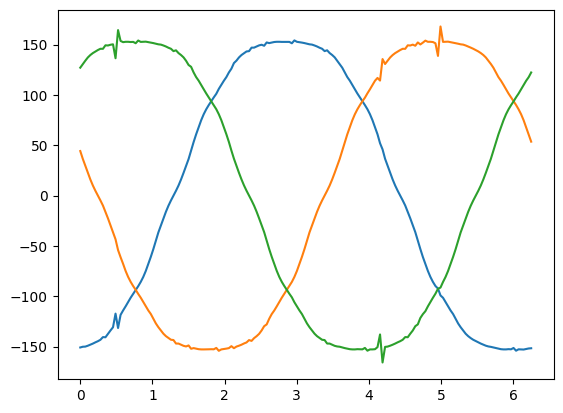

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(j1_df['angles'], j1_df['Back_EMF_0'], label='Back_EMF_0')
ax.plot(j1_df['angles'], j1_df['Back_EMF_1'], label='Back_EMF_1')
ax.plot(j1_df['angles'], j1_df['Back_EMF_2'], label='Back_EMF_2')

In [21]:
j2_result = api.get_job(j2.id)
for artifact in j2_result['artifacts']:
    print(artifact['type'], artifact['url'], artifact['id'])
time.sleep(1)    

GMSH_MESH file://Kebnekaise//app/job-data/65a9823fb949f7971a289cd7/case.msh 6f01ae4054ec1b6fd4cb2142
ELMER_SIF file://Kebnekaise//app/job-data/65a9823fb949f7971a289cd7/case.sif 8d4e3954183236cf545d3135
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823fb949f7971a289cd7/results/step_t0001.vtu 6ab900af95c832e5d53387d3
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823fb949f7971a289cd7/results/step_t0180.vtu 9c400636e82dd45720624ff6
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823fb949f7971a289cd7/postprocess/FluxPlot.gif 0dc0f1d4635adce424ec678c
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65a9823fb949f7971a289cd7/postprocess/Torque.png 0d2d8aa37f6d4a6cacfde1ce
RESULT_PLOT file://Kebnekaise//app/job-data/65a9823fb949f7971a289cd7/postprocess/Currents.png 62099b859cd2a307a08e1548
RESULT_PLOT file://Kebnekaise//app/job-data/65a9823fb949f7971a289cd7/postprocess/FluxLinkage.png b2d7c55da3

In [22]:
j2_result_data = [art for art in j2_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j2_df = pd.read_csv(j2_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)

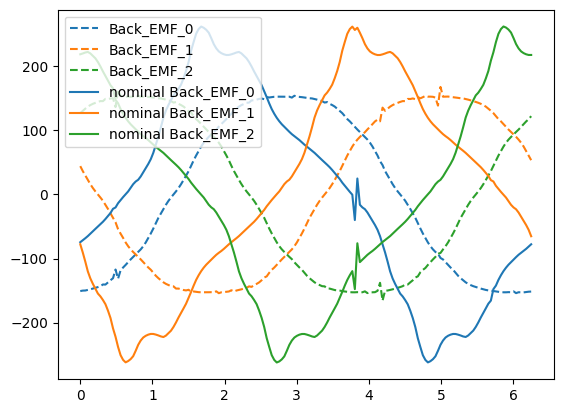

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
l1, = ax.plot(j1_df['angles'], j1_df['Back_EMF_0'], label='Back_EMF_0', linestyle='--')
l2, = ax.plot(j1_df['angles'], j1_df['Back_EMF_1'], label='Back_EMF_1', linestyle='--',)
l3, = ax.plot(j1_df['angles'], j1_df['Back_EMF_2'], label='Back_EMF_2', linestyle='--')
ax.plot(j2_df['angles'], j2_df['Back_EMF_0'], label='nominal Back_EMF_0', color=l1.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_1'], label='nominal Back_EMF_1', color=l2.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_2'], label='nominal Back_EMF_2', color=l3.get_color())
ax.legend()

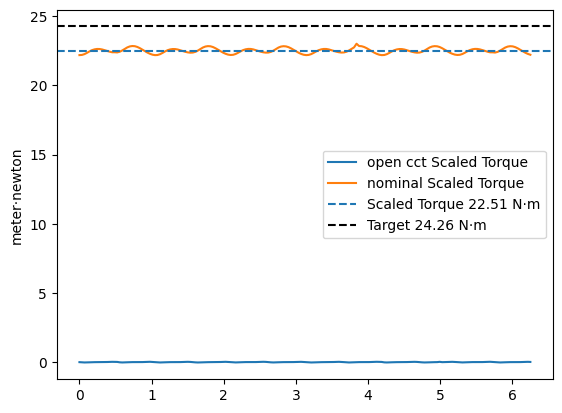

In [24]:

fig = plt.figure(2)
ax = fig.add_subplot(111)
l1, = ax.plot(j1_df['angles'], j1_df['Scaled Torque'], label='open cct Scaled Torque')
l2, = ax.plot(j2_df['angles'], j2_df['Scaled Torque'], label='nominal Scaled Torque')
mean_torque = j2_df['Scaled Torque'].mean()
ax.axhline( mean_torque, label=f'Scaled Torque {mean_torque:2.4~P}', linestyle='--')
target_torque = 24.26 * q.N * q.m
ax.axhline( target_torque, label=f'Target {target_torque:2.4~P}', color='k', linestyle='--')

ax.legend()

In [25]:
m1_df = pd.read_csv("Machine_Back_emfs_Machine_1.csv", skiprows=1, header=[0, 1], index_col=[0]).pint.quantify(level=-1)
m1_df.head()


Angle_mech,Phase A,Phase B,Phase C
2.250,150.876,-18.697,-138.917
3.375,147.385,-2.225,-145.669
4.500,141.627,12.43,-149.624
5.625,133.637,32.13,-152.796
6.750,122.62,49.57,-154.232


In [26]:
m1_df['Angles electrical'] = pint_pandas.PintArray(m1_df.index * m1.rotor['number_poles'] / 2, dtype="pint[degree]")
m1_df.dtypes

/home/mjfwest/repositories/Lonely-Tool-Cult/.venv/lib/python3.10/site-packages/pandas/core/indexes/base.py:527: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return Index(np.asarray(data), dtype=dtype, copy=copy, name=name)


Angle_mech
Phase A                pint[volt]
Phase B                pint[volt]
Phase C                pint[volt]
Angles electrical    pint[degree]
dtype: object

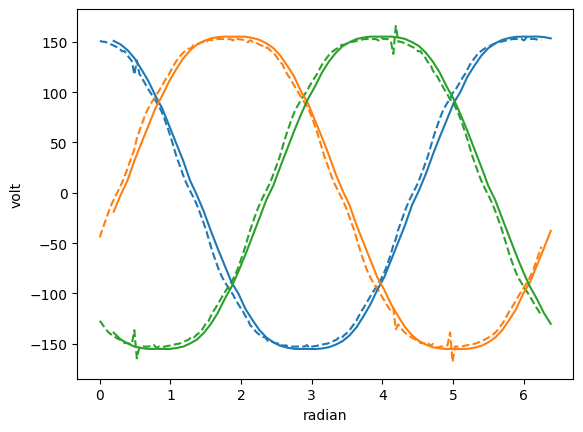

In [27]:
fig = plt.figure(3)
ax = fig.add_subplot(111)
l1, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_0'], label='Back_EMF_0', linestyle='--')
l2, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_1'], label='Back_EMF_1', linestyle='--',)
l3, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_2'], label='Back_EMF_2', linestyle='--')
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase A'], label='Phase A', color=l1.get_color())
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase B'], label='Phase B', color=l2.get_color())
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase C'], label='Phase C', color=l3.get_color())


100 <Unit('delta_degree_Celsius')>